This notebook uses play-level NFL data. We build multiple classifiers to partition what are sucessful offense or defense plays to determine what are the most significant features. The feature are our takeaway here. We will run the full feature set through a logistic regression classifier and a low grade neural network classifier. For logistic we do a nested k-fold cross validation with hyperparameter tuning. Its scores will be average accuracy and accuracy sigma. The neural network is a three-layer 20-node variety. Its scores are accuracy when stopped during training and accuracy versus a holdout test set. Next we run three feature importance tests: chi-squared, Lasso, and random forest classifier. We normalize each model’s importance scores across features, the sum of which is each feature’s composite score. We rank this composite score and assess a cutoff point for feature reduction. We input this reduced dataset through the same logistic and neural network classifiers as before. If the accuracy scores are approximately the same, we proceed to a larger four-layer 100-node network and obtain via k-fold cross validation average accuracy and accuracy sigma. If all these accuracy scores jibe we proceed to real world analysis as indicated above






Some code attribution:
1. Raschka, S. (2015). Python Machine Learning. Birmingham, England: Packt Publishing.
2. Lopez de Prado, M. (2018). Advances in Financial Machine Learning. Nashville, TN: John Wiley & Sons.
3. Hull, J.C. (2019). Machine Learning in Business.  




In [23]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

In [3]:
# bring in preprocessed data
location = 'C:/Users/bscot/OneDrive/Documents/Top Down Football/Game Data'

supervised_onehot = pd.read_csv(os.path.join(location, 'unsupervised_onehot.csv'))
print(supervised_onehot.shape)

(318399, 195)


In [4]:
# drop rows by quant 
supervised_onehot_offense = supervised_onehot[supervised_onehot.Down > 0]
print(supervised_onehot_offense.shape)

(267910, 195)


In [9]:
# drop cols by name
# this has been an iterative process
supervised_onehot_offense_x = supervised_onehot_offense.drop(['Yards',
                                                              'SeriesFirstDown',
                                                              'IsNoPlay',
                                                              'PlayType_EXTRA POINT',
                                                              'PlayType_PUNT',
                                                              'PlayType_KICK OFF',
                                                              'IsTwoPointConversion',
                                                              'PlayType_TIMEOUT',
                                                              'PlayType_FIELD GOAL',
                                                              'Formation_FIELD GOAL',
                                                              'PlayType_NO PLAY',
                                                              'Formation_PUNT',
                                                              'PlayType_TWO-POINT CONVERSION',
                                                              'PlayType_EXCEPTION',
                                                              'PlayType_QB KNEEL',
                                                              'PenaltyYards',
                                                              'PenaltyType_Unpenalized',
                                                              'IsPenaltyAccepted',
                                                              'IsPenalty',
                                                              'IsTouchdown',
                                                              'PlayType_CLOCK STOP',
                                                              'IsIncomplete'],axis=1)

supervised_onehot_offense_y = supervised_onehot_offense[['Yards']]

print(supervised_onehot_offense_x.shape)
print(supervised_onehot_offense_y.shape)

(267910, 173)
(267910, 1)


In [15]:
# scale data
transformer = StandardScaler().fit(supervised_onehot_offense_x)
X_scaled = transformer.transform(supervised_onehot_offense_x)
X = pd.DataFrame(X_scaled, columns = supervised_onehot_offense_x.columns)
y = supervised_onehot_offense_y
y_boole = supervised_onehot_offense_y


# divide data into training set and test set for holdout method
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=100)

print('X train dataframe is: ',X_train.shape)
print('y train dataframe is: ',y_train.shape)
print('X test dataframe is: ',X_test.shape)
print('y test dataframe is: ',y_test.shape)

X train dataframe is:  (214328, 173)
y train dataframe is:  (214328, 1)
X test dataframe is:  (53582, 173)
y test dataframe is:  (53582, 1)


In [16]:
# need to make y 0 or 1 for classifier
# train
y_train.loc[y_train['Yards'] <= 3] = 0
y_train.loc[y_train['Yards'] >= 4] = 1
# test
y_test.loc[y_test['Yards'] <= 3] = 0
y_test.loc[y_test['Yards'] >= 4] = 1
# all
y_boole.loc[y_boole['Yards'] <= 3] = 0
y_boole.loc[y_boole['Yards'] >= 4] = 1

C:\Users\bscot\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\bscot\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\bscot\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [17]:
# check y-target contents and balance
print(y_train.describe())
print(y_test.describe())
print(y_boole.describe())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y_boole.value_counts(normalize=True))

               Yards
count  214328.000000
mean        0.421937
std         0.493870
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
              Yards
count  53582.000000
mean       0.419469
std        0.493477
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
               Yards
count  267910.000000
mean        0.421444
std         0.493791
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Yards
0.0      0.578063
1.0      0.421937
dtype: float64
Yards
0.0      0.580531
1.0      0.419469
dtype: float64
Yards
0.0      0.578556
1.0      0.421444
dtype: float64


In [18]:
# logistic regression classifier
# Using entire feature set

t0_ = time()
# create logistic pipeline
#
pca = PCA()
#
# regression object
lr = LogisticRegression(random_state=1, solver='lbfgs',multi_class='ovr',max_iter=4000)
# lr = LogisticRegression()


# Pipeline of two steps
pipeline_lr = Pipeline(steps=[('pca', pca), ('lr', lr)])
# lasso parameter space
parameters_lr = {
    'pca__n_components': [25,75,125,150],
    'lr__C': np.logspace(-4, 4, 4),
}

# perform 5x2 nested cross validation
optimize_lr = GridSearchCV(pipeline_lr, parameters_lr,scoring='accuracy', cv=2)
# understand features and hyperparams
optimize_lr.fit(X,y_boole.values.ravel())
# 
scores_lr = cross_val_score(optimize_lr,X, y_boole, scoring='accuracy', cv=5, n_jobs=-1)
#
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_lr),np.std(scores_lr)))
print('Best C:', optimize_lr.best_estimator_.get_params()['lr__C'])
print('Best Number Of Components:', optimize_lr.best_estimator_.get_params()['pca__n_components'])
t0_lr1 = (time() - t0_)
print("done in %0.3fs" % (t0_lr1))

CV accuracy: 0.653 +/- 0.013
Best C: 10000.0
Best Number Of Components: 125
done in 1296.346s


In [19]:
# define first NN model
offense_classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='sigmoid', 
                          name='fc1', input_shape=(173,)),
    tf.keras.layers.Dense(20, activation = 'sigmoid'),
    tf.keras.layers.Dense(20, activation = 'sigmoid'),
    tf.keras.layers.Dense(2, name='fc2', activation='softmax')])

#offense_classifier.summary()

In [20]:
# compile model
offense_classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

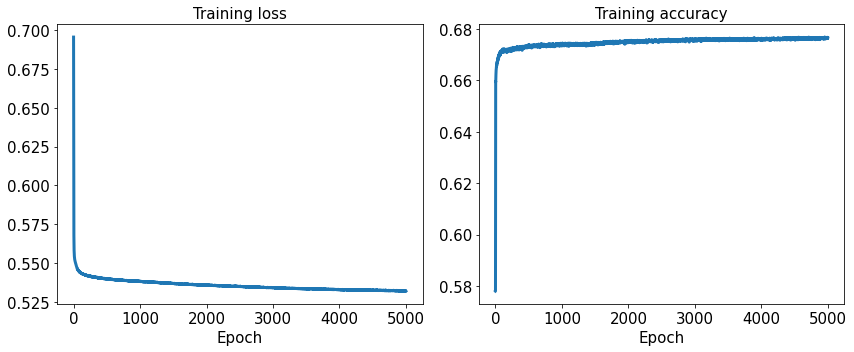

Test loss: 0.5668   Test Acc.: 0.6684
done in 1953.111s


In [21]:
t0 = time()

# fit model
num_epochs = 5000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

history = offense_classifier.fit(X_train,y_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

print('Max Acc Training: ',max(hist['accuracy']))
results = offense_classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))
t0_nn0 = (time() - t0)
print("done in %0.3fs" % (t0_nn0))

C:\Users\bscot\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\bscot\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [ 14  63  85  86 117 129 140 148 159 166 168] are constant.
  UserWarning)
C:\Users\bscot\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\bscot\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


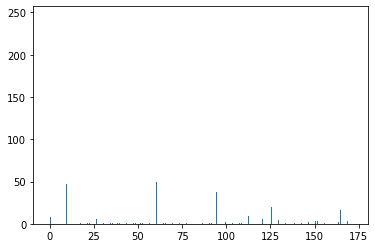

In [25]:
# use univariate score to rank coeffs
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

X_indices = np.arange(X.shape[-1])

selector = SelectKBest(f_classif, k=173)
selector.fit(X, y)
chi_importance = -np.log10(selector.pvalues_)
plt.bar(X_indices - .45, chi_importance, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

feature_names = np.array(X.columns)

In [26]:
# export
chisq_coeff_export = list(zip(feature_names, chi_importance))
chisq_coeff_export = pd.DataFrame(chisq_coeff_export)
chisq_coeff_export.to_csv (r'C:/Users/bscot/OneDrive/Documents/Top Down Football/Game Data/chisq_coeff.csv', index = False, header=True)
print(chisq_coeff_export)

                                          0          1
0                                    GameId   5.327273
1                                   Quarter   7.961847
2                                    Minute  46.765101
3                                    Second   5.341649
4                                      Down        inf
..                                      ...        ...
168                  PenaltyType_TOUCHBACK.        NaN
169                    PenaltyType_TRIPPING   3.075747
170       PenaltyType_UNNECESSARY ROUGHNESS   3.358913
171     PenaltyType_UNSPORTSMANLIKE CONDUCT   0.176793
172  PenaltyType_YAC 14.  A FLAG WAS THROWN   0.617384

[173 rows x 2 columns]


C:\Users\bscot\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 1) GameId                         0.123764
 2) Second                         0.111139
 3) Day of Year                    0.105651
 4) YardLine                       0.093558
 5) YardLineFixed                  0.090968
 6) Minute                         0.084400
 7) ToGo                           0.055366
 8) Down                           0.047557
 9) Quarter                        0.042040
10) Month of Year                  0.030981
11) IsRush                         0.021949
12) PassType_NA                    0.014770
13) PlayType_PASS                  0.014284
14) IsPass                         0.014218
15) PlayType_RUSH                  0.011580
16) RushDirection_NA               0.011056
17) Formation_SHOTGUN              0.010008
18) PlayType_SCRAMBLE              0.009092
19) PassType_SHORT MIDDLE          0.007286
20) PlayType_SACK                  0.006917
21) IsSack                         0.006865
22) Formation_UNDER CENTER         0.006543
23) PassType_SHORT LEFT         

C:\Users\bscot\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


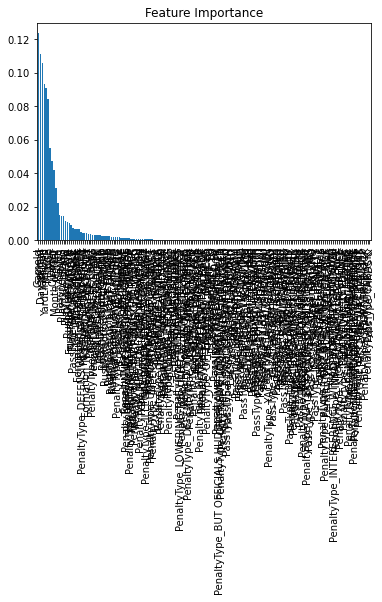

In [27]:
# use random forest classifier for feature importance
# from Raschka

feature_names = np.array(X.columns)

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X, y_boole)
randforest_importance = forest.feature_importances_

indices = np.argsort(randforest_importance)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feature_names[indices[f]], 
                            randforest_importance[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        randforest_importance[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [28]:
# export
randforest_coeff_export = list(zip(feature_names, randforest_importance))
randforest_coeff_export = pd.DataFrame(randforest_coeff_export)
randforest_coeff_export.to_csv (r'C:/Users/bscot/OneDrive/Documents/Top Down Football/Game Data/randforest_coeff.csv', index = False, header=True)
print(randforest_coeff_export)

                                          0         1
0                                    GameId  0.123764
1                                   Quarter  0.042040
2                                    Minute  0.084400
3                                    Second  0.111139
4                                      Down  0.047557
..                                      ...       ...
168                  PenaltyType_TOUCHBACK.  0.000000
169                    PenaltyType_TRIPPING  0.000122
170       PenaltyType_UNNECESSARY ROUGHNESS  0.001394
171     PenaltyType_UNSPORTSMANLIKE CONDUCT  0.000423
172  PenaltyType_YAC 14.  A FLAG WAS THROWN  0.000002

[173 rows x 2 columns]


C:\Users\bscot\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\bscot\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1234.1238954709552, tolerance: 6.532420555036939
  positive)


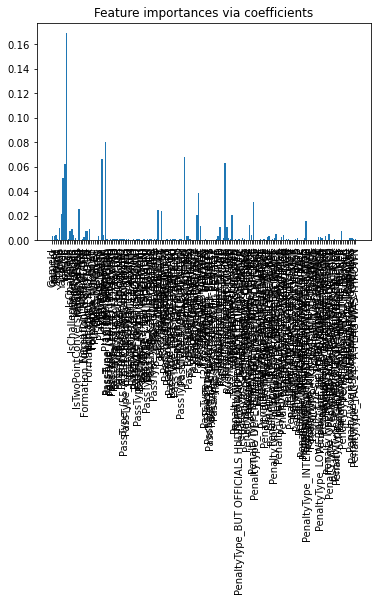

n lasso features greater than zero: 134


In [29]:
# lasso for feature reduction
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py
lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X.columns)
plt.bar(height=importance, x=feature_names)
plt.xticks(rotation=90)
plt.title("Feature importances via coefficients")
plt.show()
print('n lasso features greater than zero:',(importance > 0.00).sum())

In [30]:
# export
lasso_coeff_export = list(zip(feature_names, importance))
lasso_coeff_export = pd.DataFrame(lasso_coeff_export)
lasso_coeff_export.to_csv (r'C:/Users/bscot/OneDrive/Documents/Top Down Football/Game Data/lasso_coeff.csv', index = False, header=True)
print(lasso_coeff_export)

                                          0         1
0                                    GameId  0.003740
1                                   Quarter  0.003431
2                                    Minute  0.004220
3                                    Second  0.000590
4                                      Down  0.010278
..                                      ...       ...
168                  PenaltyType_TOUCHBACK.  0.000000
169                    PenaltyType_TRIPPING  0.002119
170       PenaltyType_UNNECESSARY ROUGHNESS  0.001576
171     PenaltyType_UNSPORTSMANLIKE CONDUCT  0.001366
172  PenaltyType_YAC 14.  A FLAG WAS THROWN  0.000571

[173 rows x 2 columns]


In [ ]:
# removed penalty features
'PenaltyType_DEFENSIVE PASS INTERFERENCE',
'PenaltyType_NEUTRAL ZONE INFRACTION',
'PenaltyType_ENCROACHMENT',
'PenaltyType_DEFENSIVE HOLDING',
'PenaltyType_DEFENSIVE OFFSIDE',
'PenaltyType_ROUGHING THE PASSER',
'PenaltyType_DEFENSIVE 12 ON-FIELD',
'PenaltyType_ILLEGAL CONTACT',
'PenaltyType_ILLEGAL SUBSTITUTION',
'PenaltyType_DEFENSIVE TOO MANY MEN ON FIELD',
'PenaltyType_INTERFERENCE WITH OPPORTUNITY TO CATCH',
'PenaltyType_DELAY OF GAME',
'PenaltyType_INTENTIONAL GROUNDING',
'PenaltyType_OFFENSIVE PASS INTERFERENCE',
'PenaltyType_ILLEGAL BLOCK ABOVE THE WAIST',
'PenaltyType_OFFENSIVE HOLDING',
'PenaltyType_FALSE START',
'PenaltyType_ILLEGAL FORMATION',
'PenaltyType_ILLEGAL FORWARD PASS',
'PenaltyType_LOW BLOCK',
'PenaltyType_TRIPPING',
'PenaltyType_ILLEGAL USE OF HANDS',
'PenaltyType_INELIGIBLE DOWNFIELD PASS',
'PenaltyType_OFFENSIVE 12 ON-FIELD',
'PenaltyType_CHOP BLOCK',
'PenaltyType_ILLEGAL PEELBACK',
'PenaltyType_RUNNING INTO THE KICKER',
'PenaltyType_PLAYER OUT OF BOUNDS ON PUNT',
'PenaltyType_INELIGIBLE DOWNFIELD KICK',
'PenaltyType_ROUGHING THE KICKER',
'PenaltyType_FAIR CATCH INTERFERENCE',
'PenaltyType_ILLEGAL TOUCH KICK',
'PenaltyType_HORSE COLLAR TACKLE',
'PenaltyType_UNNECESSARY ROUGHNESS',
'PenaltyType_LOWERING THE HEAD TO INITIATE CONTACT',
'PlayType_PENALTY',
'PenaltyType_UNSPORTSMANLIKE CONDUCT',
'PenaltyType_FACE MASK (15 YARDS)',
'IsChallengeReversed',
'IsChallenge'

In [41]:
# feature names
culled_features = ['IsFumble',
'PlayType_FUMBLES',
'IsInterception',
'PlayType_SACK',
'IsSack',
'ToGo',
'Down',
'YardLineFixed',
'YardLine',
'YardLineDirection_OPP',
'YardLineDirection_OWN',
'Formation_NO HUDDLE SHOTGUN',
'Formation_UNDER CENTER',
'Formation_SHOTGUN',
'PlayType_Other',
'Formation_NO HUDDLE',
'IsPass',
'PlayType_SCRAMBLE',
'PassType_NA',
'PassType_SHORT MIDDLE',
'PassType_DEEP LEFT',
'PassType_DEEP RIGHT',
'PassType_SHORT LEFT',
'PassType_DEEP MIDDLE',
'PlayType_PASS',
'PassType_SHORT RIGHT',
'PassType_NOT LISTED',
'PassType_PASS RULING,',
'PassType_LEFT TO',
'IsRush',
'PlayType_RUSH',
'RushDirection_NA',
'RushDirection_RIGHT END',
'RushDirection_LEFT END',
'RushDirection_CENTER',
'RushDirection_LEFT TACKLE',
'RushDirection_RIGHT GUARD',
'RushDirection_RIGHT TACKLE',
'RushDirection_LEFT GUARD',
'Day of Year',
'Month of Year',
'Second',
'Minute',
'Quarter',
'GameId',
]

In [47]:
#
X_culled = X[culled_features]
X_train_culled = X_train[culled_features]
X_test_culled = X_test[culled_features]
print(X_culled.shape)
print(X_train_culled.shape)
print(X_test_culled.shape)

(267910, 45)
(214328, 45)
(53582, 45)


In [43]:
# logistic regression classifier
t0_ = time()
# create logistic pipeline
#
pca = PCA()
#
# regression object
lr = LogisticRegression(random_state=1, solver='lbfgs',multi_class='ovr',max_iter=4000)
# lr = LogisticRegression()


# Pipeline of two steps
pipeline_lr = Pipeline(steps=[('pca', pca), ('lr', lr)])
# lasso parameter space
parameters_lr = {
    'pca__n_components': [10,20,30,40],
    'lr__C': np.logspace(-4, 4, 4),
}

# perform 5x2 nested cross validation
optimize_lr = GridSearchCV(pipeline_lr, parameters_lr,scoring='accuracy', cv=2)
# understand features and hyperparams
optimize_lr.fit(X_culled,y_boole.values.ravel())
# 
scores_lr = cross_val_score(optimize_lr,X_culled, y_boole, scoring='accuracy', cv=5, n_jobs=-1)
#
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_lr),np.std(scores_lr)))
print('Best C:', optimize_lr.best_estimator_.get_params()['lr__C'])
print('Best Number Of Components:', optimize_lr.best_estimator_.get_params()['pca__n_components'])
t0_lr2 = (time() - t0_)
print("done in %0.3fs" % (t0_lr2))

CV accuracy: 0.655 +/- 0.004
Best C: 10000.0
Best Number Of Components: 30
done in 116.813s


In [48]:
# define model
offense_classifier_lasso = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='sigmoid', 
                          name='fc1', input_shape=(45,)),
    tf.keras.layers.Dense(20, activation = 'sigmoid'),
    tf.keras.layers.Dense(20, activation = 'sigmoid'),
    tf.keras.layers.Dense(2, name='fc2', activation='softmax')])

#offense_classifier_lasso.summary()

In [49]:
# compile model
offense_classifier_lasso.compile(optimizer='adam',
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])

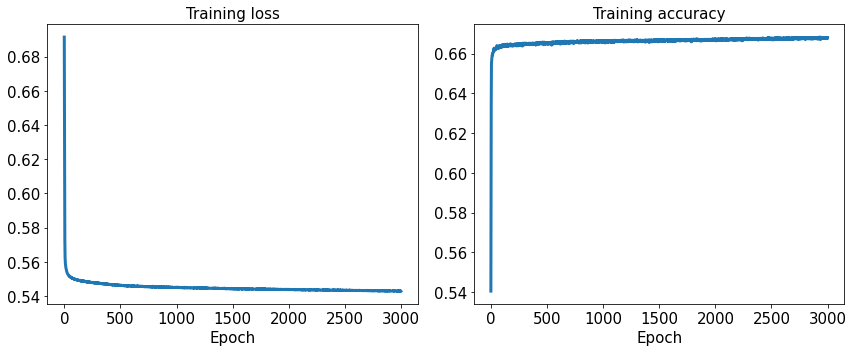

Test loss: 0.5509   Test Acc.: 0.6615
done in 882.876s


In [50]:
t0 = time()

# fit model
num_epochs = 3000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

history = offense_classifier_lasso.fit(X_train_culled, y_train, epochs=num_epochs,
                                       steps_per_epoch=steps_per_epoch, 
                                       verbose=0)

hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

print('Max Acc Training: ',max(hist['accuracy']))
results = offense_classifier_lasso.evaluate(X_test_culled, y_test, verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))
t0_nn2 = (time() - t0)
print("done in %0.3fs" % (t0_nn2))

In [51]:
# Run final cross validation model
# increase layers 
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(100, input_shape=(45,) , activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(100, activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(100, activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(100, activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(2))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [52]:
t0 = time()

# train model 
num_epochs = 3000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size/batch_size)
# data set length must be >= (training/batch)*epochs

n_split=5

for train_index,test_index in KFold(n_split).split(X_culled):
    # need to convert pandas to numpy w iloc
    X_train_kfold,X_test_kfold = X_culled.iloc[train_index],X_culled.iloc[test_index]
    y_train_kfold,y_test_kfold = y_boole.iloc[train_index],y_boole.iloc[test_index]
    
    model=create_model()
    model.fit(X_train_kfold, y_train_kfold,
            epochs=num_epochs,
            steps_per_epoch=steps_per_epoch,
            #callbacks=[checkpoint,kickout],
            verbose=0)
    
    #print('Model evaluation ',model.evaluate(X_test_kfold,y_test))
    
    results = offense_classifier_lasso.evaluate(X_test_kfold, y_test_kfold, verbose=0)
    print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

    
t0_nn3 = (time() - t0)
print("done in %0.3fs" % (t0_nn3))

Test loss: 0.5371   Test Acc.: 0.6715
Test loss: 0.5503   Test Acc.: 0.6606
Test loss: 0.5444   Test Acc.: 0.6668
Test loss: 0.5464   Test Acc.: 0.6669
Test loss: 0.5435   Test Acc.: 0.6677
done in 8465.381s
